# IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# LOAD DATA

In [2]:
data = pd.read_csv('/kaggle/input/sentiment-emotion-dataset/balanced_data.csv', encoding="utf-8").drop(['Unnamed: 0'],axis=1)
data.columns = ['sentimen','emosi','ulasan']
data

,sentimen,emosi,ulasan
0,0,0,menyenangkan bikin kesal handphone realme c 11...
1,0,0,kalau tidak niat bikin gamenya bagus hapus saj...
2,0,0,tidak dari sebelum update game sndiri update 3...
3,0,0,semenjak update buruk main bareng disconeted s...
4,0,0,bangkrut sodara sudah hapus saja aplikasinya h...
...,...,...,...
43225,0,5,parafrase kali mncoba untuk verifikasi gagal h...
43226,0,5,kali mncoba untuk verifikasi gagal hsil swafot...
43227,0,5,kali pakai prosesnya kirim danamon mandiri man...
43228,0,5,parafrase parafrase parafrase: kali pakai pros...


# EXPLORATORY DATA ANALYSIS

## 1) Data Info & Data Describe

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43230 entries, 0 to 43229
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  43230 non-null  int64 
 1   emosi     43230 non-null  int64 
 2   ulasan    42410 non-null  object
dtypes: int64(2), object(1)
memory usage: 1013.3+ KB


In [4]:
data.describe()

,sentimen,emosi
count,43230.000000,43230.000000
mean,0.833333,2.500000
std,0.897538,1.707845
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.500000,2.500000
75%,2.000000,4.000000
max,2.000000,5.000000


## 2) CEK NILAI KOSONG DATA

In [5]:
print("Apakah ada NaN di dataset?")
print(data.isna().any().any())  

print("\nJumlah NaN di setiap kolom:")
print(data.isna().sum())


print("\nPersentase NaN di setiap kolom:")
print((data.isna().mean() * 100).round(2))


print("\nContoh baris yang mengandung NaN:")
print(data[data.isna().any(axis=1)].head())


print("\nTotal seluruh nilai NaN dalam dataset:")
print(data.isna().sum().sum())

print("\nKolom yang memiliki NaN:")
cols_with_nan = data.columns[data.isna().any()].tolist()
print(cols_with_nan)


Apakah ada NaN di dataset?
True

Jumlah NaN di setiap kolom:
sentimen      0
emosi         0
ulasan      820
dtype: int64

Persentase NaN di setiap kolom:
sentimen    0.0
emosi       0.0
ulasan      1.9
dtype: float64

Contoh baris yang mengandung NaN:
      sentimen  emosi ulasan
1893         0      0    NaN
2788         0      1    NaN
2799         0      1    NaN
2969         0      1    NaN
4673         2      2    NaN

Total seluruh nilai NaN dalam dataset:
820

Kolom yang memiliki NaN:
['ulasan']


## 3) Cek Unik Dalam Data

## 3.1 Unik Sentimen

In [6]:
print("Nilai unik sentimen:")
print(data['sentimen'].value_counts())


Nilai unik sentimen:
sentimen
0    21615
2    14410
1     7205
Name: count, dtype: int64


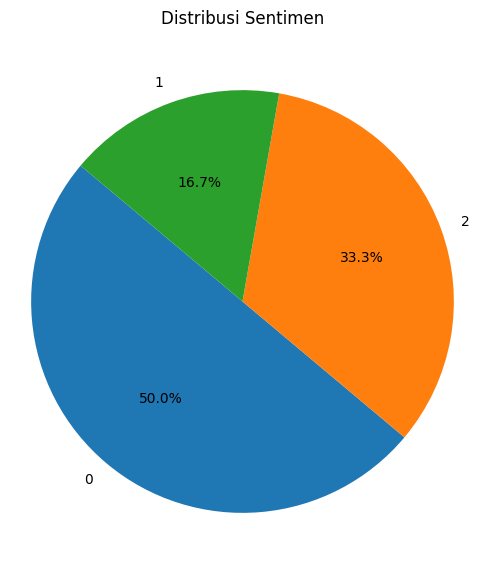

In [7]:
sentimen_counts = data['sentimen'].value_counts()
# Pie chart
plt.figure(figsize=(6,7))
plt.pie(sentimen_counts, labels=sentimen_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Sentimen')
plt.axis('equal')  # Biar pie-nya bulat sempurna
plt.show()


## 3.2 Unik Emosi

In [8]:
print("Nilai unik emosi:")
print(data['emosi'].value_counts())

Nilai unik emosi:
emosi
0    7205
1    7205
2    7205
3    7205
5    7205
4    7205
Name: count, dtype: int64


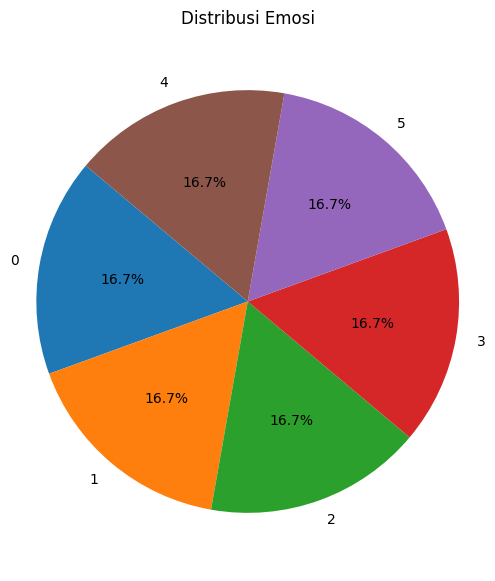

In [9]:
sentimen_counts = data['emosi'].value_counts()
# Pie chart
plt.figure(figsize=(6,7))
plt.pie(sentimen_counts, labels=sentimen_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Emosi')
plt.axis('equal')  # Biar pie-nya bulat sempurna
plt.show()


# PREPROCESSING DATA & FEATURE ENGINEERING

## 1. Bersihkan Data dari karakter aneh, tanda baca, url, spasi berlebih dan angka

In [10]:
def bersihkan_teks(teks):
    if not isinstance(teks, str):
        return None  # kalau bukan string, skip aja

    if re.search(r'[^\x00-\x7F]', teks):
        return None

    # Proses pembersihan
    teks = teks.lower()
    teks = re.sub(r"http\S+|www\S+|https\S+", '', teks)
    teks = re.sub(r"[^a-zA-Z0-9\s]", '', teks)
    teks = re.sub(r"\s+", ' ', teks).strip()
    teks = ' '.join([word for word in teks.split() if word not in stop_words])
    return teks


In [11]:
data

,sentimen,emosi,ulasan
0,0,0,menyenangkan bikin kesal handphone realme c 11...
1,0,0,kalau tidak niat bikin gamenya bagus hapus saj...
2,0,0,tidak dari sebelum update game sndiri update 3...
3,0,0,semenjak update buruk main bareng disconeted s...
4,0,0,bangkrut sodara sudah hapus saja aplikasinya h...
...,...,...,...
43225,0,5,parafrase kali mncoba untuk verifikasi gagal h...
43226,0,5,kali mncoba untuk verifikasi gagal hsil swafot...
43227,0,5,kali pakai prosesnya kirim danamon mandiri man...
43228,0,5,parafrase parafrase parafrase: kali pakai pros...


In [12]:
# Terapkan fungsi ke kolom 'ulasan'
data['ulasan_bersih'] = data['ulasan'].apply(bersihkan_teks)

# Buang baris yang hasil pembersihannya None (karena mengandung karakter aneh)
data = data.dropna(subset=['ulasan_bersih']).reset_index(drop=True)
data = data.drop(['ulasan'],axis=1)
data

,sentimen,emosi,ulasan_bersih
0,0,0,menyenangkan bikin kesal handphone realme c 11...
1,0,0,niat bikin gamenya bagus hapus gamenya narik m...
2,0,0,update game sndiri update 37 suka sndiri main ...
3,0,0,semenjak update buruk main bareng disconeted s...
4,0,0,bangkrut sodara hapus aplikasinya handphone km...
...,...,...,...
41776,0,5,parafrase kali mncoba verifikasi gagal hsil sw...
41777,0,5,kali mncoba verifikasi gagal hsil swafoto foto...
41778,0,5,kali pakai prosesnya kirim danamon mandiri man...
41779,0,5,parafrase parafrase parafrase kali pakai prose...


## 2) BERSIHKAN DATANYA DARI KATA - KATA TIDAK FORMAL / TIDAK BAKU / GAUL

In [13]:
import pandas as pd
from collections import Counter
import re

# Contoh: data['ulasan_bersih'] udah tersedia
all_words = ' '.join(data['ulasan_bersih']).split()
word_freq = Counter(all_words)

# Ambil kata-kata pendek dan mencurigakan
slang_candidates = [word for word in word_freq if len(word) < 5 and word_freq[word] > 10]

print(slang_candidates)


['c', '11', 'nya', 'ajj', 'sein', 'ya', 'niat', 'game', 'bug', '5', '37', 'suka', 'main', 'lgi', 'stir', 'pas', 'off', 'ttep', 'bus', 'kmu', 'indo', 'on', 'you', 'deh', 'tol', 'i', 'rugi', 'nkri', 'mati', 'sok', 'tilt', 'mnit', 'jam', '930', '2230', 'uang', 'bca', 'bank', 'jlek', 'skli', 'bles', 'anjg', 'tidk', 'enak', 'va', 'hoi', 'mutu', 'spam', 'beli', 'xhd', 'babi', 'chat', '1', 'dana', 'cs', '8', 'cuti', 'tim', '4x', 'sih', 'd', 'abis', 'isi', 'loop', 'solo', 'arah', '500', 'nol', 'ads', 'klik', 'adu', 'map', 'heng', 'afk', 'cwe', 'kubu', 'ah', 'plus', 'trx', 'su', 'app', '3x', 'foto', 'sono', 'dftr', 'flip', 'gua', 'apus', 'dh', 'dlu', 'v', '371', 'dev', 'biar', 'ahh', 'seru', 'mode', 'play', '2', '1000', 'taik', 'bawa', 'si', 'coba', 'full', 'apk', '3', 'apl', '4', 'aneh', 'maaf', 'dobo', 'hape', 'tu', 'uanh', 'anak', 'logo', 'eh', 'k', 'lobi', 'free', 'fire', 'bos', 'rame', 'bkin', 'php', 'in', 'alfa', 'bner', 'user', 'shd', 'taii', 'a', 'cari', 'ajak', 'kota', 'kali', 'apan', 

In [14]:
# List slang
slang_list = ['hp', 'ga', 'udah', 'nya', 'mod', 'tau', 'sein', 'kalo', 'ngak', 'niat', 'aja', 'dah', 'mulu',
              'ntar', 'gak', 'dri', 'udh', 'tpi', 'msih', 'sma', 'hoax', 'cek', 'n', 'dg', 'ya', 'deh', 'kena',
              'ajah', 'ni', 'dr', 'ku', 'yg', 'smua', 'bgt', 'skrg', 'gk', 'krn', 'oy', 'pake', 'kau', 'maen',
              'duit', 'laen', 'kaya', 'tdk', 'sihh', 'gini', 'w', 'auto', 'isi', 'klo', 'gw', 'lg', 'nih', 'woy',
              'nge', 'klik', 'nggk', 'jdi', 'ny', 'plis', 'dlm', 'ah', 'gede', 'gitu', 'apa2', 'biar', 'ajg',
              'ak', 'tuh', 'si', 'coba', 'gtu', 'gx', 'nga', 'aneh', 'maaf', 'yaa', 'ajh', 'eh', 'ff', 'dll',
              'gmn', 'mw', 'min', 'sy', 'sdh', 'lo', 'jngn', 'lu', 'sih', 'bngt', 'ama', 'bs', 'kn', 'smpe',
              'trs', 'orng', 'baku', 'kta', 'sya', 'kaga', 'cht', 'trus', 'msk', 'jgn', 'cmn', 'dpt', 'asu',
              'tai', 'org', 'gue', 'y', 'aj', 'koq', 'ngga', 'donk', 'iya', 'kyk', 'cma', 'bls', 'hrs', 'utk',
              'msh', 'byk', 'koin', 'pke', 'kl', 'wa', 'gmna', 'liat', 'mah', 'nnti', 'lho', 'maap', 'krna',
              'msuk', 'sia', 'baca', 'ane', 'aga', 'masi', 'ngk', 'blom', 'bang', 'pls', 'pd', 'bait', 'ok',
              'bnyk', 'ato', 'gigi', 'ampe', 'loh', 'oke', 'lahh', 'napa', 'nyaa', 'kek', 'gada', 'mu', 'yah',
              'cewe', 'ngga', 'uda', 'nyah', 'rek', 'anj', 'klw', 'tmn', 'haha', 'gaes', 'ad', 'yng', 'pda',
              'hati', 'tlng', 'smga', 'smg', 'bg', 'ksih', 'yh', 'aman', 'aq', 'gan', 'dpat', 'ubah', 'jt',
              'td', 'tlg', 'ka', 'dech', 'lbih', 'apik', 'joss', 'cri', 'smp', 'jos', 'dehh', 'fps', 'wahh',
              'okey', 'jln', 'br', 'ijin', 'ijin']

# Mapping slang ke kata baku
slang_to_baku = {
    'hp': 'handphone', 'ga': 'tidak', 'udah': 'sudah', 'nya': 'nya', 'mod': 'modifikasi',
    'tau': 'tahu', 'sein': 'lampu sein', 'kalo': 'kalau', 'ngak': 'tidak', 'niat': 'niat',
    'aja': 'saja', 'dah': 'sudah', 'mulu': 'terus-menerus', 'ntar': 'nanti', 'gak': 'tidak',
    'dri': 'dari', 'udh': 'sudah', 'tpi': 'tapi', 'msih': 'masih', 'sma': 'sama', 'hoax': 'berita bohong',
    'cek': 'periksa', 'n': 'dan', 'dg': 'dengan', 'ya': 'ya', 'deh': 'deh', 'kena': 'terkena',
    'ajah': 'saja', 'ni': 'ini', 'dr': 'dari', 'ku': 'saya', 'yg': 'yang', 'smua': 'semua',
    'bgt': 'banget', 'skrg': 'sekarang', 'gk': 'tidak', 'krn': 'karena', 'oy': 'hoi', 'pake': 'pakai',
    'kau': 'kamu', 'maen': 'main', 'duit': 'uang', 'laen': 'lain', 'kaya': 'seperti', 'tdk': 'tidak',
    'sihh': 'sih', 'gini': 'begini', 'w': 'saya', 'auto': 'otomatis', 'isi': 'isi', 'klo': 'kalau',
    'gw': 'saya', 'lg': 'lagi', 'nih': 'ini', 'woy': 'hoi', 'nge': 'sedang', 'klik': 'klik',
    'nggk': 'tidak', 'jdi': 'jadi', 'ny': 'nya', 'plis': 'tolong', 'dlm': 'dalam', 'ah': 'ah',
    'gede': 'besar', 'gitu': 'begitu', 'apa2': 'apa-apa', 'biar': 'biar', 'ajg': 'anjing',
    'ak': 'saya', 'tuh': 'itu', 'si': 'si', 'coba': 'coba', 'gtu': 'begitu', 'gx': 'tidak',
    'nga': 'tidak', 'aneh': 'aneh', 'maaf': 'maaf', 'yaa': 'ya', 'ajh': 'saja', 'eh': 'eh',
    'ff': 'free fire', 'dll': 'dan lain-lain', 'gmn': 'bagaimana', 'mw': 'mau', 'min': 'admin',
    'sy': 'saya', 'sdh': 'sudah', 'lo': 'kamu', 'jngn': 'jangan', 'lu': 'kamu', 'sih': 'sih',
    'bngt': 'banget', 'ama': 'sama', 'bs': 'bisa', 'kn': 'kan', 'smpe': 'sampai', 'trs': 'terus',
    'orng': 'orang', 'baku': 'baku', 'kta': 'kita', 'sya': 'saya', 'kaga': 'tidak', 'cht': 'chat',
    'trus': 'terus', 'msk': 'masuk', 'jgn': 'jangan', 'cmn': 'cuma', 'dpt': 'dapat', 'asu': 'anjing',
    'tai': 'tinja', 'org': 'orang', 'gue': 'saya', 'y': 'ya', 'aj': 'saja', 'koq': 'kok', 'ngga': 'tidak',
    'donk': 'dong', 'iya': 'ya', 'kyk': 'seperti', 'cma': 'cuma', 'bls': 'balas', 'hrs': 'harus',
    'utk': 'untuk', 'msh': 'masih', 'byk': 'banyak', 'koin': 'koin', 'pke': 'pakai', 'kl': 'kalau',
    'wa': 'whatsapp', 'gmna': 'bagaimana', 'liat': 'lihat', 'mah': 'mah', 'nnti': 'nanti',
    'lho': 'loh', 'maap': 'maaf', 'krna': 'karena', 'msuk': 'masuk', 'sia': 'sia-sia', 'baca': 'baca',
    'ane': 'saya', 'aga': 'agak', 'masi': 'masih', 'ngk': 'tidak', 'blom': 'belum', 'bang': 'abang',
    'pls': 'tolong', 'pd': 'pada', 'bait': 'baik', 'ok': 'oke', 'bnyk': 'banyak', 'ato': 'atau',
    'gigi': 'gigi', 'ampe': 'sampai', 'loh': 'loh', 'oke': 'oke', 'lahh': 'lah', 'napa': 'kenapa',
    'nyaa': 'nya', 'kek': 'seperti', 'gada': 'tidak ada', 'mu': 'kamu', 'yah': 'ya', 'cewe': 'perempuan',
    'ngga': 'tidak', 'uda': 'sudah', 'nyah': 'nya', 'rek': 'rekening', 'anj': 'anjing',
    'klw': 'kalau', 'tmn': 'teman', 'haha': 'tertawa', 'gaes': 'teman-teman', 'ad': 'ada',
    'yng': 'yang', 'pda': 'pada', 'hati': 'hati', 'tlng': 'tolong', 'smga': 'semoga', 'smg': 'semoga',
    'bg': 'bang', 'ksih': 'kasih', 'yh': 'ya', 'aman': 'aman', 'aq': 'saya', 'gan': 'juragan',
    'dpat': 'dapat', 'ubah': 'ubah', 'jt': 'juta', 'td': 'tadi', 'tlg': 'tolong', 'ka': 'kakak',
    'dech': 'deh', 'lbih': 'lebih', 'apik': 'bagus', 'joss': 'mantap', 'cri': 'cari', 'smp': 'sampai',
    'jos': 'mantap', 'dehh': 'deh', 'fps': 'frame per second', 'wahh': 'wah', 'okey': 'oke',
    'jln': 'jalan', 'br': 'baru', 'ijin': 'izin', 'sblm' : 'sebelum', 'sblum' : 'sebelum', "tqpi":"tapi", 
    "nmor":"nomor", "boong" :"bohong", "g":"tidak", "bsa":"bisa", "jelal":"jelas" ,"apded":"update", "nmr":"nomor"
    ,"bgus":"bagus" , "kya":"seperti","cba":"coba", "lv":"level","lvl":"level",'jg':'juga'
}

# Fungsi konversi slang ke baku
def ubah_ke_baku(kalimat):
    kata2 = kalimat.lower().split()
    hasil = [slang_to_baku.get(kata, kata) for kata in kata2]
    return ' '.join(hasil)

# Terapkan ke kolom ulasan_bersih
data['ulasan_baku'] = data['ulasan_bersih'].apply(ubah_ke_baku)

# Tampilkan hasil contoh
print(data[['ulasan_bersih', 'ulasan_baku']])

                                           ulasan_bersih  \
0      menyenangkan bikin kesal handphone realme c 11...   
1      niat bikin gamenya bagus hapus gamenya narik m...   
2      update game sndiri update 37 suka sndiri main ...   
3      semenjak update buruk main bareng disconeted s...   
4      bangkrut sodara hapus aplikasinya handphone km...   
...                                                  ...   
41776  parafrase kali mncoba verifikasi gagal hsil sw...   
41777  kali mncoba verifikasi gagal hsil swafoto foto...   
41778  kali pakai prosesnya kirim danamon mandiri man...   
41779  parafrase parafrase parafrase kali pakai prose...   
41780  parafrase parafrase kali pakai prosesnya kirim...   

                                             ulasan_baku  
0      menyenangkan bikin kesal handphone realme c 11...  
1      niat bikin gamenya bagus hapus gamenya narik m...  
2      update game sndiri update 37 suka sndiri main ...  
3      semenjak update buruk main bareng di

In [15]:
data

,sentimen,emosi,ulasan_bersih,ulasan_baku
0,0,0,menyenangkan bikin kesal handphone realme c 11...,menyenangkan bikin kesal handphone realme c 11...
1,0,0,niat bikin gamenya bagus hapus gamenya narik m...,niat bikin gamenya bagus hapus gamenya narik m...
2,0,0,update game sndiri update 37 suka sndiri main ...,update game sndiri update 37 suka sndiri main ...
3,0,0,semenjak update buruk main bareng disconeted s...,semenjak update buruk main bareng disconeted s...
4,0,0,bangkrut sodara hapus aplikasinya handphone km...,bangkrut sodara hapus aplikasinya handphone km...
...,...,...,...,...
41776,0,5,parafrase kali mncoba verifikasi gagal hsil sw...,parafrase kali mncoba verifikasi gagal hsil sw...
41777,0,5,kali mncoba verifikasi gagal hsil swafoto foto...,kali mncoba verifikasi gagal hsil swafoto foto...
41778,0,5,kali pakai prosesnya kirim danamon mandiri man...,kali pakai prosesnya kirim danamon mandiri man...
41779,0,5,parafrase parafrase parafrase kali pakai prose...,parafrase parafrase parafrase kali pakai prose...


## 3) DATA YANG SUDAH BERSIH 

In [16]:
data = data.drop(['ulasan_bersih'],axis=1)
data

,sentimen,emosi,ulasan_baku
0,0,0,menyenangkan bikin kesal handphone realme c 11...
1,0,0,niat bikin gamenya bagus hapus gamenya narik m...
2,0,0,update game sndiri update 37 suka sndiri main ...
3,0,0,semenjak update buruk main bareng disconeted s...
4,0,0,bangkrut sodara hapus aplikasinya handphone km...
...,...,...,...
41776,0,5,parafrase kali mncoba verifikasi gagal hsil sw...
41777,0,5,kali mncoba verifikasi gagal hsil swafoto foto...
41778,0,5,kali pakai prosesnya kirim danamon mandiri man...
41779,0,5,parafrase parafrase parafrase kali pakai prose...


## 4) CEK KESEIMBANGAN KELAS

In [17]:
for column in data.columns:
    print(f"Value counts untuk kolom: {column}")
    print(data[column].value_counts())
    print("\n" + "-"*40 + "\n")


Value counts untuk kolom: sentimen
sentimen
0    20921
2    13716
1     7144
Name: count, dtype: int64

----------------------------------------

Value counts untuk kolom: emosi
emosi
2    7150
4    7144
5    7035
0    6956
1    6930
3    6566
Name: count, dtype: int64

----------------------------------------

Value counts untuk kolom: ulasan_baku
ulasan_baku
parafrase                          504
                                   146
parafrase parafrase                 89
bagus                               77
parafrase suka                      61
                                  ... 
menguntungkan                        1
meningkatkan kepahlawanan            1
meningkatkan kualitas berbahasa      1
meningkatkan nasionalisme            1
nya dgn membantu                     1
Name: count, Length: 35319, dtype: int64

----------------------------------------



In [18]:
from sklearn.preprocessing import LabelEncoder

# Buat encoder
encoder_sentimen = LabelEncoder()
encoder_emosi = LabelEncoder()

# Encode dan simpan ke kolom baru
data['sentimen'] = encoder_sentimen.fit_transform(data['sentimen'])
data['emosi'] = encoder_emosi.fit_transform(data['emosi'])

# Cek hasil mapping
print("Mapping Sentimen:")
for i, label in enumerate(encoder_sentimen.classes_):
    print(f"{label} → {i}")

print("\nMapping Emosi:")
for i, label in enumerate(encoder_emosi.classes_):
    print(f"{label} → {i}")


Mapping Sentimen:
0 → 0
1 → 1
2 → 2

Mapping Emosi:
0 → 0
1 → 1
2 → 2
3 → 3
4 → 4
5 → 5


In [19]:
data

,sentimen,emosi,ulasan_baku
0,0,0,menyenangkan bikin kesal handphone realme c 11...
1,0,0,niat bikin gamenya bagus hapus gamenya narik m...
2,0,0,update game sndiri update 37 suka sndiri main ...
3,0,0,semenjak update buruk main bareng disconeted s...
4,0,0,bangkrut sodara hapus aplikasinya handphone km...
...,...,...,...
41776,0,5,parafrase kali mncoba verifikasi gagal hsil sw...
41777,0,5,kali mncoba verifikasi gagal hsil swafoto foto...
41778,0,5,kali pakai prosesnya kirim danamon mandiri man...
41779,0,5,parafrase parafrase parafrase kali pakai prose...


In [20]:
for column in data.columns:
    print(f"Value counts untuk kolom: {column}")
    print(data[column].value_counts())
    print("\n" + "-"*40 + "\n")


Value counts untuk kolom: sentimen
sentimen
0    20921
2    13716
1     7144
Name: count, dtype: int64

----------------------------------------

Value counts untuk kolom: emosi
emosi
2    7150
4    7144
5    7035
0    6956
1    6930
3    6566
Name: count, dtype: int64

----------------------------------------

Value counts untuk kolom: ulasan_baku
ulasan_baku
parafrase                          504
                                   146
parafrase parafrase                 89
bagus                               77
parafrase suka                      61
                                  ... 
menguntungkan                        1
meningkatkan kepahlawanan            1
meningkatkan kualitas berbahasa      1
meningkatkan nasionalisme            1
nya dgn membantu                     1
Name: count, Length: 35319, dtype: int64

----------------------------------------



# PERBANYAK DATA DENGAN CARA PARAFRASE

In [21]:
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# import torch
# import pandas as pd
# from tqdm import tqdm

# # Load tokenizer & model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# # Fungsi parafrase
# def paraphrase(text, num_return_sequences=3):  # Bisa diubah sesuai kebutuhan
#     input_text = f"parafrase: {text} </s>"
#     input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
#     outputs = model.generate(
#         input_ids,
#         do_sample=True,
#         max_length=512,
#         top_k=120,
#         top_p=0.95,
#         num_return_sequences=num_return_sequences
#     )
#     return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# # --- BACA DATA ---
# # Misal kamu sudah punya dataframe bernama 'data'
# # Jika datanya dari CSV:
# # data = pd.read_csv('namafile.csv')

# # Kolom yang akan diparafrase
# tulisan_asli = data['ulasan_baku'].tolist()
# sentimen = data['sentimen'].tolist()
# emosi = data['emosi'].tolist()

# # Untuk menyimpan hasil parafrase
# new_data = {
#     'sentimen': [],
#     'emosi': [],
#     'ulasan_baku': []
# }

# # Parafrase tiap baris
# for i in tqdm(range(len(tulisan_asli))):
#     teks = tulisan_asli[i]
#     label_sentimen = sentimen[i]
#     label_emosi = emosi[i]

#     try:
#         hasil_parafrase = paraphrase(teks, num_return_sequences=4)
#         for versi in hasil_parafrase:
#             new_data['sentimen'].append(label_sentimen)
#             new_data['emosi'].append(label_emosi)
#             new_data['ulasan_baku'].append(versi)
#     except Exception as e:
#         print(f"Error pada baris {i}: {e}")
#         continue

# # Gabungkan dengan data asli jika ingin
# df_parafrase = pd.DataFrame(new_data)
# df_augmented = pd.concat([data, df_parafrase], ignore_index=True)

# # Simpan hasilnya (opsional)
# # df_augmented.to_csv("data_augmented_parafrase.csv", index=False)

# df_augmented


In [22]:
# balanced_data.to_csv('balanced_data.csv')
# balanced_data

# CEK DISTRIBUSI DATA SETELAH AUGMENTASI DENGAN PARAFRASE

In [23]:
# data_augmented

In [24]:
# print("Nilai unik sentiment:")
# print(data_augmented['sentimen'].value_counts())

In [25]:
# sentimen_counts = data_augmented['sentimen'].value_counts()
# # Pie chart
# plt.figure(figsize=(6,7))
# plt.pie(sentimen_counts, labels=sentimen_counts.index, autopct='%1.1f%%', startangle=140)
# plt.title('Distribusi Sentimen')
# plt.axis('equal')  # Biar pie-nya bulat sempurna
# plt.show()


In [26]:
# print("Nilai unik emosi:")
# print(data_augmented['emosi'].value_counts())

In [27]:
# sentimen_counts = data_augmented['emosi'].value_counts()
# # Pie chart
# plt.figure(figsize=(6,7))
# plt.pie(sentimen_counts, labels=sentimen_counts.index, autopct='%1.1f%%', startangle=140)
# plt.title('Distribusi Emosi')
# plt.axis('equal')  # Biar pie-nya bulat sempurna
# plt.show()


# MEMPERBANYAK DATA DENGAN CARA PARAFRASE BIASA

In [28]:
import pandas as pd
import random

# Asumsikan df sudah didefinisikan sebelumnya (data asli)
df = data.copy()  # Atau: pd.read_csv('nama_file.csv') kalau dari file

# Hitung jumlah data tambahan (3x dari data asli)
jumlah_tambahan = int(len(df) * 3)

# Ambil subset data acak untuk augmentasi (bisa sampling dengan pengembalian)
df_subset = df.sample(n=jumlah_tambahan, replace=True, random_state=42).reset_index(drop=True)

# -------------------------
# Fungsi dummy untuk paraphrasing ringan
# Ganti ini dengan paraphraser model jika punya (T5, IndoBART, dsb.)
# -------------------------
def simple_paraphrase(text):
    words = text.split()
    if len(words) > 5:
        random.shuffle(words)
        return " ".join(words) + "."
    return text + " ya."

# Terapkan paraphrasing ke kolom ulasan_baku
df_subset['ulasan_baku'] = df_subset['ulasan_baku'].apply(simple_paraphrase)

# Gabungkan data asli dan hasil augmentasi
df_final = pd.concat([df, df_subset], ignore_index=True)

# Cek ukuran data
print(f"Jumlah data asli    : {len(df)}")
print(f"Jumlah data tambahan: {len(df_subset)}")
print(f"Total data akhir    : {len(df_final)}")

# Simpan ke file (opsional)
# df_final.to_csv('ulasan_augment_4x.csv', index=False)
# print("Data sudah siap sebagai total 4x lipat dari data asli.")


Jumlah data asli    : 41781
Jumlah data tambahan: 125343
Total data akhir    : 167124


## PENENTUAN DATA FITUR DAN DATA TARGET + VEKTORISASI DATA FITUR

In [29]:
data = df_final.copy()

In [30]:
data

,sentimen,emosi,ulasan_baku
0,0,0,menyenangkan bikin kesal handphone realme c 11...
1,0,0,niat bikin gamenya bagus hapus gamenya narik m...
2,0,0,update game sndiri update 37 suka sndiri main ...
3,0,0,semenjak update buruk main bareng disconeted s...
4,0,0,bangkrut sodara hapus aplikasinya handphone km...
...,...,...,...
167119,2,3,parefame hehe hehe hehe psngan cari hehe hehe.
167120,0,1,akun indonesia akun dicuridisalahgunakan indon...
167121,1,4,anak 19 malang ya.
167122,2,2,top game game indonesia anak iniapa.


In [31]:
X = data['ulasan_baku']
y = data['sentimen']

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_vec = tfidf.fit_transform(X)

In [32]:
print(X_vec)

  (0, 1006)	0.14332688147283892
  (0, 8851)	0.1209057631105334
  (0, 3918)	0.24836929089818977
  (0, 6360)	0.1226758952431772
  (0, 4857)	0.1413061511926453
  (0, 4854)	0.2708491813217692
  (0, 6404)	0.13327615499944612
  (0, 9392)	0.1354245906608846
  (0, 6363)	0.13119989071979155
  (0, 5905)	0.11871403668474764
  (0, 6303)	0.13100711106983315
  (0, 5024)	0.11702638547627847
  (0, 5371)	0.1409324779389052
  (0, 1602)	0.1413061511926453
  (0, 7971)	0.09081249976269615
  (0, 9271)	0.052518188954137096
  (0, 5223)	0.09583990329864564
  (0, 975)	0.05537525095971274
  (0, 8849)	0.07828137120511577
  (0, 9884)	0.02966256158400123
  (0, 3910)	0.24362838731271874
  (0, 8241)	0.12699261220732952
  (0, 4852)	0.28976850070006316
  (0, 4233)	0.05842767435694003
  (0, 2656)	0.12042223961871014
  :	:
  (167120, 2501)	0.42323946152557
  (167120, 7415)	0.5643192820340933
  (167120, 5535)	0.4250010995534636
  (167120, 283)	0.32259257476759373
  (167120, 3739)	0.17171664442856033
  (167121, 5247)	0.794

# TUNING HYPERPARAMETER SVM - SENTIMEN

In [33]:
from sklearn.model_selection import train_test_split

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)


In [34]:
import optuna
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Fungsi objective Optuna
def objective(trial):
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    max_iter = trial.suggest_int('max_iter', 1000, 10000, step=1000)
    tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    dual = trial.suggest_categorical('dual', [True, False])

    # Kombinasi tidak valid → hindari crash
    if loss == 'hinge' and dual is False:
        raise optuna.exceptions.TrialPruned()
    

    model = LinearSVC(
        C=C,
        max_iter=max_iter,
        class_weight='balanced',
        tol=tol,
        loss=loss,
        dual=dual,
        fit_intercept=fit_intercept
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    return score

# Jalankan Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Output hasil terbaik
print("\n=== Best Hyperparameters ===")
print(study.best_params)
print(f"Best Accuracy: {study.best_value:.4f}")


[I 2025-04-22 07:00:46,914] A new study created in memory with name: no-name-e5e7ac6d-127c-47e5-9418-c1d3eeb612de
[I 2025-04-22 07:00:47,801] Trial 0 finished with value: 0.8741959611069559 and parameters: {'C': 1.9786624470900245, 'max_iter': 1000, 'tol': 0.0070727653922847186, 'loss': 'squared_hinge', 'fit_intercept': False, 'dual': True}. Best is trial 0 with value: 0.8741959611069559.
[I 2025-04-22 07:00:48,357] Trial 1 finished with value: 0.8540314136125654 and parameters: {'C': 0.060526408460256066, 'max_iter': 8000, 'tol': 1.2855813472155666e-05, 'loss': 'squared_hinge', 'fit_intercept': True, 'dual': True}. Best is trial 0 with value: 0.8741959611069559.
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-04-22 07:01:19,920] Trial 2 finished with value: 0.8677636499626028 and parameters: {'C': 1.1304506647453472, 'max_iter': 10000, 'tol': 2.8785377158666


=== Best Hyperparameters ===
{'C': 7.893724425421321, 'max_iter': 6000, 'tol': 0.0004149798955150243, 'loss': 'squared_hinge', 'fit_intercept': True, 'dual': False}
Best Accuracy: 0.8787


# TRAINING SVM SENTIMENT - DENGAN HASIL HYPERPARAMETER TERBAIK

{'C': 7.893724425421321, 'max_iter': 6000, 'tol': 0.0004149798955150243, 'loss': 'squared_hinge', 'fit_intercept': True, 'dual': False}
=== Hasil Evaluasi Sentimen ===
Akurasi  : 0.8806
Presisi  : 0.8840
Recall   : 0.8806
F1-Score : 0.8817

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93     16740
           1       0.71      0.78      0.75      5757
           2       0.91      0.86      0.89     10928

    accuracy                           0.88     33425
   macro avg       0.85      0.86      0.85     33425
weighted avg       0.88      0.88      0.88     33425



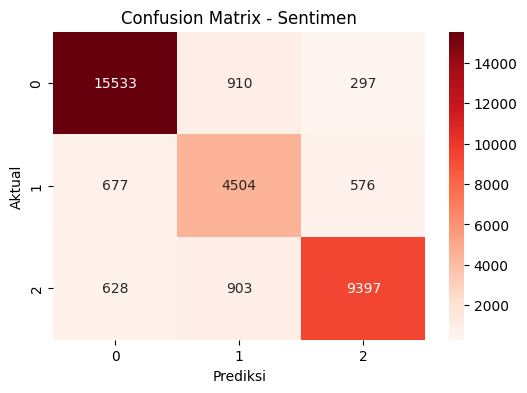

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

best = study.best_params
print(best)
# Target Sentimen
y_sentimen = data['sentimen']

# Split data
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sentimen, test_size=0.2, shuffle=True)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_vec, y_sentimen, test_size=0.2, shuffle=True, stratify=y_sentimen
)

# Train model SVM untuk Sentimen
model_svm_sentimen = LinearSVC(**best)
model_svm_sentimen.fit(X_train_s, y_train_s)
joblib.dump(model_svm_sentimen, 'svc_model_sentimen.pkl')
# Prediksi
y_pred_s = model_svm_sentimen.predict(X_test_s)

# Evaluasi
akurasi = accuracy_score(y_test_s, y_pred_s)
presisi = precision_score(y_test_s, y_pred_s, average='weighted')
recall = recall_score(y_test_s, y_pred_s, average='weighted')
f1 = f1_score(y_test_s, y_pred_s, average='weighted')

print("=== Hasil Evaluasi Sentimen ===")
print(f"Akurasi  : {akurasi:.4f}")
print(f"Presisi  : {presisi:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test_s, y_pred_s))

# Confusion Matrix dengan seaborn
cm = confusion_matrix(y_test_s, y_pred_s)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=np.unique(y_sentimen), yticklabels=np.unique(y_sentimen))
plt.title("Confusion Matrix - Sentimen")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


# WORD CLOUD - SENTIMENT


Word Cloud untuk kelas: 0 (Negatif)


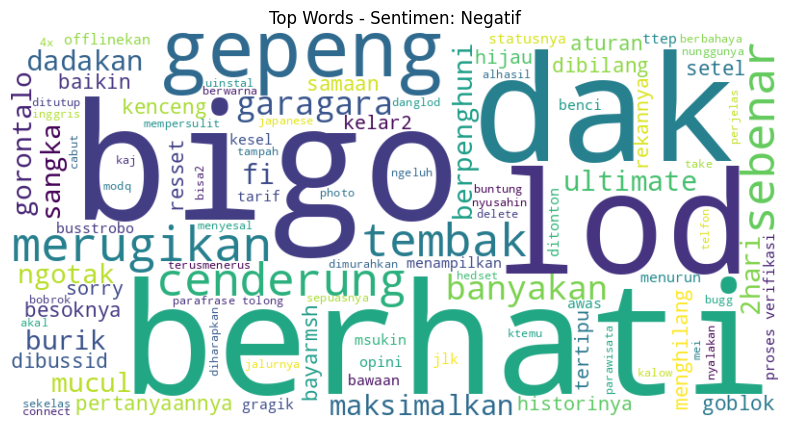


Word Cloud untuk kelas: 1 (Netral)


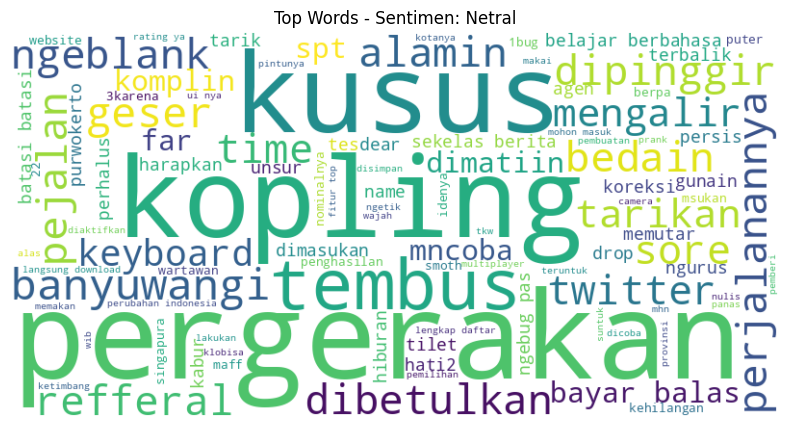


Word Cloud untuk kelas: 2 (Positif)


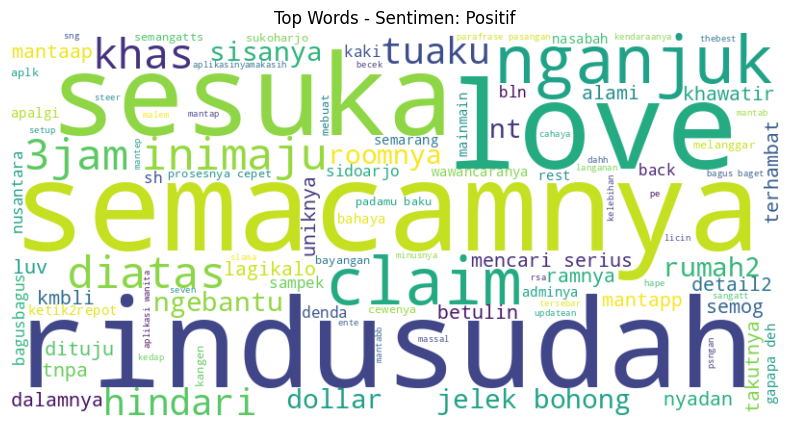

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Mapping label ke nama sentimen
label_map = {
    0: "Negatif",
    1: "Netral",
    2: "Positif"
}

# Ambil nama fitur dari TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Ambil koefisien dari model LinearSVC
coef = model_svm_sentimen.coef_

# Cek apakah klasifikasi biner atau multi-class
if coef.shape[0] == 1:
    # Binary classification
    print("\nWord Cloud untuk klasifikasi biner")
    class_coef = coef[0]
    word_weights = {word: class_coef[i] for i, word in enumerate(feature_names)}
    sorted_words = dict(sorted(word_weights.items(), key=lambda x: x[1], reverse=True)[:100])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(sorted_words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Top Words - Klasifikasi Sentimen (Biner)")
    plt.show()
else:
    # Multi-class classification
    for i, label in enumerate(model_svm_sentimen.classes_):
        label_name = label_map.get(label, str(label))  # Ubah ke nama label
        print(f"\nWord Cloud untuk kelas: {label} ({label_name})")
        class_coef = coef[i]
        word_weights = {word: class_coef[idx] for idx, word in enumerate(feature_names)}
        sorted_words = dict(sorted(word_weights.items(), key=lambda x: x[1], reverse=True)[:100])
        
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(sorted_words)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Top Words - Sentimen: {label_name}")
        plt.show()


# TUNING HYPERPARAMETER SVM - EMOSI

In [37]:
from sklearn.model_selection import train_test_split

X = data['ulasan_baku']
y = data['emosi']

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_vec = tfidf.fit_transform(X)
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)


In [38]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import optuna

# -------------------------------
# 5. Optuna tuning
def objective(trial):
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    max_iter = trial.suggest_int('max_iter', 1000, 10000, step=1000)
    tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    dual = trial.suggest_categorical('dual', [True, False])

    # Kombinasi tidak valid
    if loss == 'hinge' and dual is False:
        raise optuna.exceptions.TrialPruned()

    model = LinearSVC(
        C=C,
        max_iter=max_iter,
        class_weight='balanced',
        tol=tol,
        loss=loss,
        dual=dual,
        fit_intercept=fit_intercept
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.toarray())

    score = accuracy_score(y_test, y_pred)
    return score

# -------------------------------
# 6. Jalankan Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# -------------------------------
# 7. Output hasil terbaik
print("\n=== Best Hyperparameters ===")
print(study.best_params)
print(f"Best Accuracy: {study.best_value:.4f}")


[I 2025-04-22 07:07:41,427] A new study created in memory with name: no-name-a40aaa1b-be22-451f-907c-67c443733a52
[I 2025-04-22 07:07:41,430] Trial 0 pruned. 
[I 2025-04-22 07:07:44,646] Trial 1 finished with value: 0.8283320867614061 and parameters: {'C': 1.722864655487098, 'max_iter': 4000, 'tol': 0.0503129839366046, 'loss': 'squared_hinge', 'fit_intercept': False, 'dual': True}. Best is trial 1 with value: 0.8283320867614061.
[I 2025-04-22 07:07:48,883] Trial 2 finished with value: 0.7678982797307404 and parameters: {'C': 0.03815385785166305, 'max_iter': 6000, 'tol': 0.0032723342195712327, 'loss': 'squared_hinge', 'fit_intercept': False, 'dual': False}. Best is trial 1 with value: 0.8283320867614061.
[I 2025-04-22 07:07:52,068] Trial 3 finished with value: 0.7352879581151832 and parameters: {'C': 0.014535109995886447, 'max_iter': 6000, 'tol': 2.5889021386043926e-05, 'loss': 'squared_hinge', 'fit_intercept': False, 'dual': True}. Best is trial 1 with value: 0.8283320867614061.
[I 202


=== Best Hyperparameters ===
{'C': 9.623674298786744, 'max_iter': 2000, 'tol': 0.02670437407218601, 'loss': 'squared_hinge', 'fit_intercept': True, 'dual': True}
Best Accuracy: 0.8432


In [39]:
# X_train_bal.shape, y_train_bal.shape

In [40]:
# sentimen_counts = y_train_bal.value_counts()
# # Pie chart
# plt.figure(figsize=(6,7))
# plt.pie(sentimen_counts, labels=sentimen_counts.index, autopct='%1.1f%%', startangle=140)
# plt.title('Distribusi Emosi')
# plt.axis('equal')  # Biar pie-nya bulat sempurna
# plt.show()


In [41]:
# import optuna
# from sklearn.svm import LinearSVC
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# # Manual encoding: Negative=0, Neutral=1, Positive=2
# label_mapping = {
#     'Anger': 0,
#     'Fear': 1,
#     'Happy': 2,
#     'Love': 3,
#     'Sad': 4,
#     'Neutral': 5
# }
# y_encoded = data_augmented['emosi'].map(label_mapping)

# # Fungsi objective Optuna
# def objective(trial):
#     C = trial.suggest_float('C', 0.01, 10.0, log=True)
#     max_iter = trial.suggest_int('max_iter', 1000, 10000, step=1000)
#     tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)
#     loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
#     fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
#     dual = trial.suggest_categorical('dual', [True, False])

#     # Kombinasi tidak valid → hindari crash
#     if loss == 'hinge' and dual is False:
#         raise optuna.exceptions.TrialPruned()

#     model = LinearSVC(
#         C=C,
#         max_iter=max_iter,
#         class_weight='balanced',
#         tol=tol,
#         loss=loss,
#         dual=dual,
#         fit_intercept=fit_intercept
#     )
    
#     model.fit(X_train_bal, y_train_bal)
#     y_pred = model.predict(X_test_e_tfidf)

#     score = accuracy_score(y_test_e, y_pred)
#     return score

# # Jalankan Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Output hasil terbaik
# print("\n=== Best Hyperparameters ===")
# print(study.best_params)
# print(f"Best Accuracy: {study.best_value:.4f}")


# TRAINING SVM EMOSI - DENGAN HYPERPARAMTER TERBAIK

{'C': 9.623674298786744, 'max_iter': 2000, 'tol': 0.02670437407218601, 'loss': 'squared_hinge', 'fit_intercept': True, 'dual': True}
=== Hasil Evaluasi Sentimen ===
Akurasi  : 0.8462
Presisi  : 0.8505
Recall   : 0.8462
F1-Score : 0.8474

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      5613
           1       0.86      0.91      0.89      5515
           2       0.85      0.83      0.84      5715
           3       0.96      0.90      0.93      5213
           4       0.71      0.80      0.75      5757
           5       0.86      0.81      0.83      5612

    accuracy                           0.85     33425
   macro avg       0.85      0.85      0.85     33425
weighted avg       0.85      0.85      0.85     33425



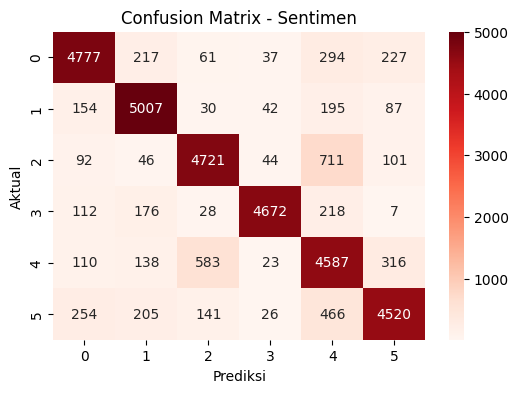

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

best = study.best_params
print(best)
# Target Sentimen
y_emosi = data['emosi']

# Split data
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sentimen, test_size=0.2, shuffle=True)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_vec, y_emosi, test_size=0.2, shuffle=True, stratify=y_emosi
)

# Train model SVM untuk Sentimen
model_svm_emosi = LinearSVC(**best)
model_svm_emosi.fit(X_train_e, y_train_e)
joblib.dump(model_svm_emosi, 'svc_model_emosi.pkl')

# Prediksi
y_pred_e = model_svm_emosi.predict(X_test_e)

# Evaluasi
akurasi = accuracy_score(y_test_e, y_pred_e)
presisi = precision_score(y_test_e, y_pred_e, average='weighted')
recall = recall_score(y_test_e, y_pred_e, average='weighted')
f1 = f1_score(y_test_e, y_pred_e, average='weighted')

print("=== Hasil Evaluasi Sentimen ===")
print(f"Akurasi  : {akurasi:.4f}")
print(f"Presisi  : {presisi:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test_e, y_pred_e))

# Confusion Matrix dengan seaborn
cm = confusion_matrix(y_test_e, y_pred_e)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=np.unique(y_emosi), yticklabels=np.unique(y_emosi))
plt.title("Confusion Matrix - Sentimen")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


# WORD CLOUD - EMOSI


Word Cloud untuk kelas: 0 (Anger)


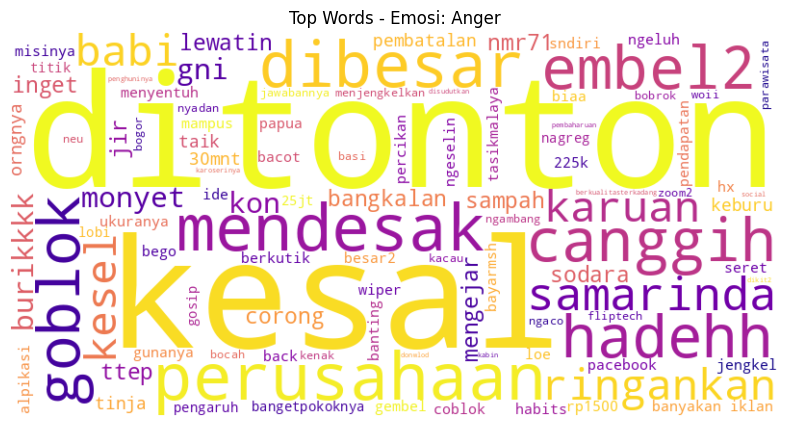


Word Cloud untuk kelas: 1 (Fear)


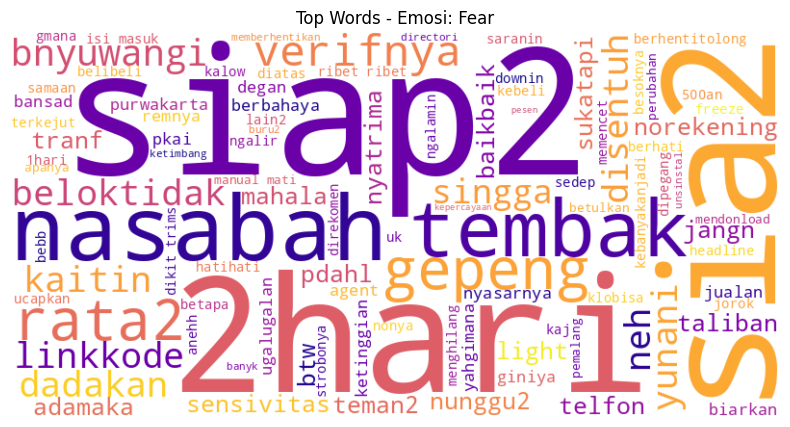


Word Cloud untuk kelas: 2 (Happy)


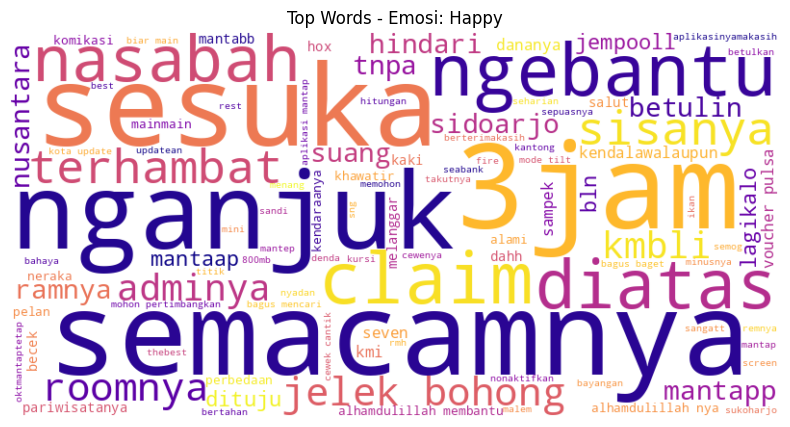


Word Cloud untuk kelas: 3 (Love)


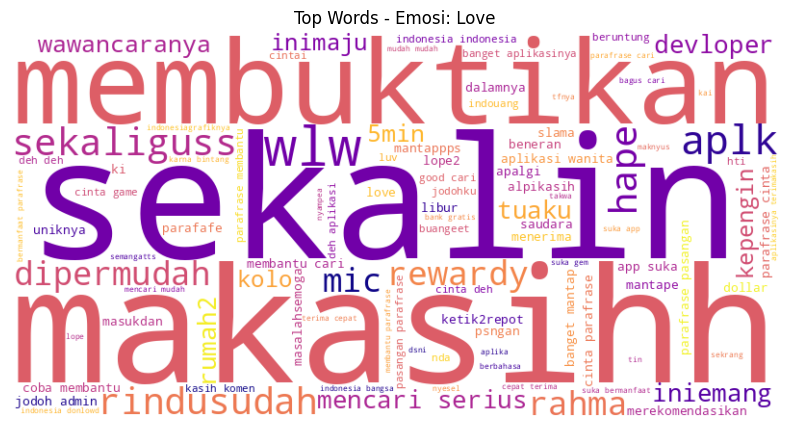


Word Cloud untuk kelas: 4 (Netral)


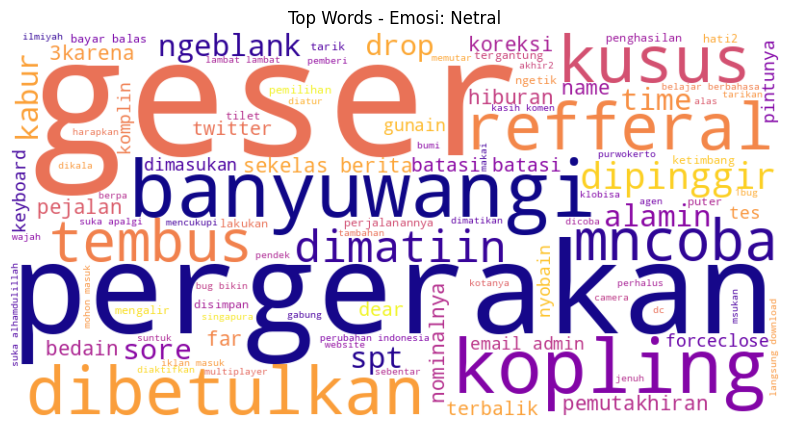


Word Cloud untuk kelas: 5 (sedih)


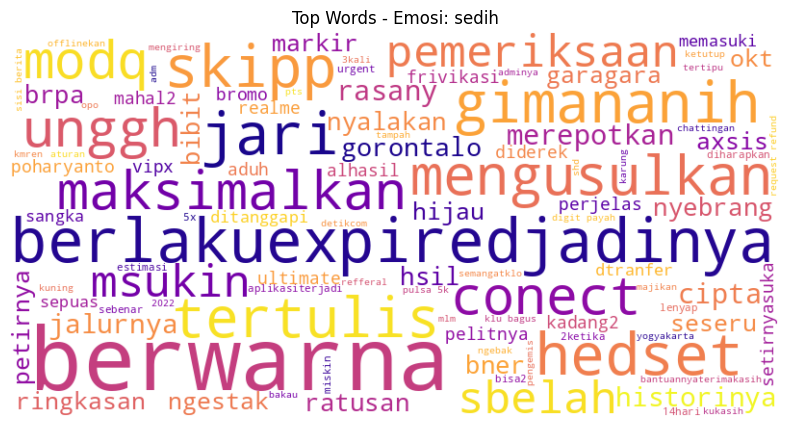

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Misalnya label emosi kamu berupa angka, dan ini mapping-nya:
label_map_emosi = {
    0: "Anger",
    1: "Fear",
    2: "Happy",
    3: "Love",
    4: "Netral",
    5: "sedih"

    
    # Sesuaikan jika label-nya berbeda
}

# Ambil nama fitur dari TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Ambil koefisien dari model LinearSVC emosi
coef_emosi = model_svm_emosi.coef_

# WordCloud untuk tiap kelas emosi
if coef_emosi.shape[0] == 1:
    print("\nWord Cloud untuk klasifikasi emosi (biner)")
    class_coef = coef_emosi[0]
    word_weights = {word: class_coef[i] for i, word in enumerate(feature_names)}
    sorted_words = dict(sorted(word_weights.items(), key=lambda x: x[1], reverse=True)[:100])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate_from_frequencies(sorted_words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Top Words - Klasifikasi Emosi (Biner)")
    plt.show()
else:
    for i, label in enumerate(model_svm_emosi.classes_):
        label_name = label_map_emosi.get(label, str(label))  # Ambil nama emosi
        print(f"\nWord Cloud untuk kelas: {label} ({label_name})")
        
        class_coef = coef_emosi[i]
        word_weights = {word: class_coef[j] for j, word in enumerate(feature_names)}
        sorted_words = dict(sorted(word_weights.items(), key=lambda x: x[1], reverse=True)[:100])
        
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate_from_frequencies(sorted_words)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Top Words - Emosi: {label_name}")
        plt.show()
